In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from robustbench.utils import load_model
# Load a model from the model zoo
model = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf',  model_dir="models")


In [3]:
## get data

In [4]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from src.utils.data_utils import create_loaders


transf = transforms.Compose([lambda x: x/1])
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# cifar_trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=None)
# cifar_testset = datasets.CIFAR10(root='data', train=False, download=True, transform=None)





batch_size = 20
n_workers = 1
data_loader = create_loaders("./data", task_config="CIFAR10",
                             batch_size=batch_size,
                             transform=transf,
                             random_state=0,
                             n_workers=n_workers)


Files already downloaded and verified


In [5]:
images, labels = next(iter(data_loader))
images, labels = images.to(device), labels.to(device)

In [38]:
from adv_lib.attacks import fmn
from tracking.tracker import PyTorchModelTrackerSetup
from logging_ import Logger
from tqdm import tqdm
import sys

logger = Logger()
tracked_model = PyTorchModelTrackerSetup(model, loss_f="CE", logger=logger)  # pytorch model


norm = float("inf")  # will use Linf norm
n_samples = 100

for b, (images, labels) in enumerate(tqdm(data_loader, total=n_samples//batch_size)):

    if b*batch_size >= n_samples:
        break

    tracked_model.setup(images, labels)
    # do attack on selected examples
    results = fmn(tracked_model, images, labels, norm, steps=200)
    tracked_model.log()
    #print(logger.loss_progress)

    #print(sum(map(lambda x: sys.getsizeof(x.storage()), logger.loss_progress)))
#     print(sys.getsizeof(logger.norm_progress.storage()))


100%|██████████| 5/5 [08:24<00:00, 100.86s/it]


In [39]:
results.shape

torch.Size([20, 3, 32, 32])

In [42]:
[x.mean() for x in logger.loss_progress]

[tensor(0.3408),
 tensor(0.4849),
 tensor(0.6915),
 tensor(0.9668),
 tensor(1.2582),
 tensor(1.5187),
 tensor(1.7311),
 tensor(1.8909),
 tensor(2.0080),
 tensor(2.0746),
 tensor(2.1105),
 tensor(2.1163),
 tensor(2.0916),
 tensor(2.0521),
 tensor(1.9953),
 tensor(1.9332),
 tensor(1.8627),
 tensor(1.7892),
 tensor(1.7174),
 tensor(1.6505),
 tensor(1.5714),
 tensor(1.5196),
 tensor(1.4643),
 tensor(1.4203),
 tensor(1.3613),
 tensor(1.3321),
 tensor(1.2858),
 tensor(1.2432),
 tensor(1.2084),
 tensor(1.1808),
 tensor(1.1412),
 tensor(1.1228),
 tensor(1.0944),
 tensor(1.0744),
 tensor(1.0454),
 tensor(1.0335),
 tensor(1.0087),
 tensor(0.9984),
 tensor(0.9823),
 tensor(0.9690),
 tensor(0.9704),
 tensor(0.9561),
 tensor(0.9576),
 tensor(0.9466),
 tensor(0.9372),
 tensor(0.9327),
 tensor(0.9263),
 tensor(0.9289),
 tensor(0.9291),
 tensor(0.9296),
 tensor(0.9323),
 tensor(0.9358),
 tensor(0.9285),
 tensor(0.9250),
 tensor(0.9230),
 tensor(0.9301),
 tensor(0.9235),
 tensor(0.9287),
 tensor(0.9247

In [44]:
model(results).argmax(dim=-1)

tensor([6, 5, 3, 4, 1, 8, 3, 2, 3, 2, 6, 6, 2, 0, 9, 6, 2, 3, 3, 1])

In [45]:
model(images).argmax(dim=-1)

tensor([8, 0, 0, 0, 7, 6, 5, 6, 1, 7, 7, 9, 1, 2, 7, 4, 8, 0, 3, 1])

In [46]:
labels

tensor([8, 0, 0, 0, 7, 6, 5, 6, 1, 9, 7, 9, 1, 2, 7, 4, 8, 0, 6, 1])

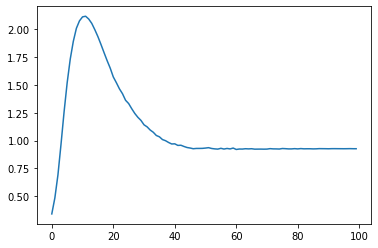

In [47]:
logger.plot_progress(kind="loss")

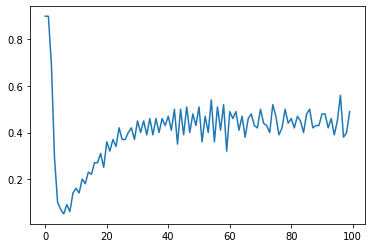

In [48]:
logger.plot_progress(kind="acc")

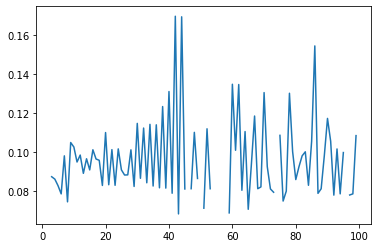

In [50]:
logger.plot_QD()

In [51]:
logger.save_all(force=True)